In [1]:
import numpy as np

In [2]:
import pandas as pd
import pickle

In [3]:
import datetime

In [4]:
usd = pd.read_csv('USD_RUB_60m.txt')
brent = pd.read_csv('BRENT_60m.txt')
american_finance = pd.read_csv('AMERICAN_FINANCE_60m.txt')
rtsi = pd.read_csv('RTSI_60m.txt')

In [5]:
rtsi_ds = rtsi[['<DATE>','<TIME>','<RTSI_HIGH>','<RTSI_LOW>']]
usd_ds = usd[['<DATE>','<TIME>','<USD_HIGH>','<USD_LOW>']]
brent_ds = brent[['<DATE>','<TIME>','<BRENT_HIGH>','<BRENT_LOW>']]
american_finance_ds = american_finance[['<DATE>','<TIME>','<AF_HIGH>','<AF_LOW>']]

In [6]:
total_ds = pd.merge(left = usd_ds, right = brent_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [7]:
total_ds = total_ds.merge(american_finance_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how = 'outer')

In [8]:
total_ds = total_ds.merge(rtsi_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [9]:
total_ds['<WEEK_DAY>'] = list(map(lambda x: (datetime.datetime.strptime(str(x),'%Y%m%d').isoweekday()),total_ds['<DATE>']))

In [10]:
total_ds['<WEEK_NUM>'] = list(map(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').isocalendar()[1], total_ds['<DATE>']))

In [11]:
total_ds['<HOUR>'] = list(map(lambda x: int(x / 10000), total_ds['<TIME>']))

In [12]:
total_ds['<MONTH>'] = list(map(lambda x: int(str(x)[4:6]), total_ds['<DATE>']))

In [13]:
del total_ds['<DATE>']
del total_ds['<TIME>']

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class FillingFreeCellsLastValue(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for column in self.column_names:
            list_ = X[column]
            list_ = np.nan_to_num(list_, nan = 0)
            tmp_val = np.median(list_[:100])
            for num,element in enumerate(list_):
                if element > 0:
                    tmp_val = element
                else:
                    list_[num] = tmp_val
            X[column] = list_
        return X

In [16]:
columns = ['<USD_HIGH>', '<USD_LOW>', 
           '<BRENT_HIGH>', '<BRENT_LOW>',
           '<AF_HIGH>', '<AF_LOW>',
           '<RTSI_HIGH>', '<RTSI_LOW>']

In [17]:
FillingFreeCellsLastValue(columns).fit_transform(total_ds)

,<USD_HIGH>,<USD_LOW>,<BRENT_HIGH>,<BRENT_LOW>,<AF_HIGH>,<AF_LOW>,<RTSI_HIGH>,<RTSI_LOW>,<WEEK_DAY>,<WEEK_NUM>,<HOUR>,<MONTH>
0,63.6750,63.6750,48.955,48.765,249.597468,249.279047,0.00,0.00,7,44,23,11
1,64.0934,62.3727,48.955,48.765,249.597468,249.279047,0.00,0.00,1,45,0,11
2,64.5614,64.0450,48.955,48.765,246.563256,246.542204,0.00,0.00,1,45,1,11
3,64.5622,63.5524,48.955,48.765,246.568520,246.542204,0.00,0.00,1,45,2,11
4,64.5603,62.6139,49.500,49.370,246.568520,246.557993,0.00,0.00,1,45,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
28552,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.29,1065.60,6,52,17,12
28553,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.37,1066.87,6,52,18,12
28554,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1068.72,1066.11,6,52,19,12
28555,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1547.20,1544.07,3,52,18,12


In [18]:
total_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28557 entries, 0 to 28556
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <USD_HIGH>    28557 non-null  float64
 1   <USD_LOW>     28557 non-null  float64
 2   <BRENT_HIGH>  28557 non-null  float64
 3   <BRENT_LOW>   28557 non-null  float64
 4   <AF_HIGH>     28557 non-null  float64
 5   <AF_LOW>      28557 non-null  float64
 6   <RTSI_HIGH>   28557 non-null  float64
 7   <RTSI_LOW>    28557 non-null  float64
 8   <WEEK_DAY>    28557 non-null  int64  
 9   <WEEK_NUM>    28557 non-null  int64  
 10  <HOUR>        28557 non-null  int64  
 11  <MONTH>       28557 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 2.8 MB


In [19]:
train_data = np.array(total_ds)

In [20]:
ds_x = []
ds_y_up = []
ds_y_down = []

days_hist= 20
days_predict = 7
hours_in_day = 24
num_history_values = hours_in_day * days_hist
num_predicted_value = hours_in_day * days_predict

threshold = 4


for num, line in enumerate(train_data[:-(num_history_values+num_predicted_value)]):
    ds_x.append(train_data[num:num+num_history_values].reshape((train_data[num:num+num_history_values].size)))

for num, line in enumerate(train_data[num_history_values:-num_predicted_value]):
    x = train_data[num_history_values+num,0]
    y = np.max(train_data[num_history_values+num:num_history_values+num+num_predicted_value,0])
    res = (y/x-1)*100
    if res >= threshold:
        ds_y_up.append(1)
    else:
        ds_y_up.append(0)
        
for num, line in enumerate(train_data[num_history_values:-num_predicted_value]):
    x = train_data[num_history_values+num,0]
    y = np.min(train_data[num_history_values+num:num_history_values+num+num_predicted_value,0])
    res = (y/x-1)*100
    if res < -threshold:
        ds_y_down.append(1)
    else:
        ds_y_down.append(0)
        

# for num in range(len(train_data[:-num_predicted_value-num_history_values])):
#     ds_hist.append(train_data[num+num_history_values:num+num_history_values+num_predicted_value,0])

In [21]:
def get_slice(x,idx):
    return x[idx+num_history_values:idx+num_history_values+num_predicted_value,0]

In [22]:
ds_hist = list(map(lambda a:get_slice(train_data,a), list(range(len(train_data[:-num_predicted_value-num_history_values])))))

In [23]:
# 
counter = 0
idxs = []
for idx,i in enumerate(ds_y_up):
    if i == 1:
        counter += 1
        idxs.append(idx)
print('percent up '+str(threshold)+'%=',counter*100/len(ds_y_up))
counter = 0
idxs = []
for idx,i in enumerate(ds_y_down):
    if i == 1:
        counter += 1
        idxs.append(idx)
print('percent down '+str(threshold)+'%=',counter*100/len(ds_y_down))

percent up 4%= 8.430972087856963
percent down 4%= 4.199362212906231


In [24]:
import matplotlib.pyplot as plt

In [25]:
def get_usd_course(x):
    return np.array(x).reshape(-1,12)[:,0]

In [26]:
def plot_graph(ds_x, ds_y, idx):
    plt.plot(get_usd_course(ds_x[2]))
    plt.plot(range(num_history_values,num_history_values+num_predicted_value),ds_hist[2], color = 'red')

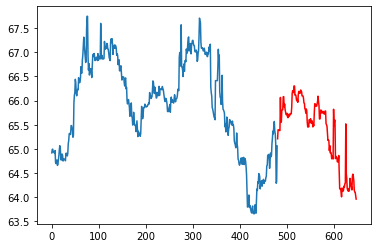

In [27]:
idx = 3550
plt.plot(get_usd_course(ds_x[idx]))
plt.plot(range(num_history_values,num_history_values+num_predicted_value),ds_hist[idx], color = 'red')

In [28]:
ds_x = np.asarray(ds_x, dtype = np.float16)
ds_y_up = np.asarray(ds_y_up, dtype = np.bool).reshape(-1,1)
ds_y_down = np.asarray(ds_y_down, dtype = np.bool).reshape(-1,1)
ds_hist = np.asarray(ds_hist, dtype = np.float16)

In [29]:
ds_y_total = np.hstack((ds_y_up,ds_y_down, ds_hist))

# shuffle total ds

In [30]:
idx = np.array(range(len(ds_y_up)))

In [31]:
np.random.shuffle(idx)

In [32]:
ds_x = ds_x[idx]
ds_y_total = ds_y_total[idx]

# split total dataset at train and test set's

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
ds_x_train, ds_x_test, ds_y_train, ds_y_test =  train_test_split(ds_x, ds_y_total, test_size = 0.2, random_state = 42)

In [36]:
def plot_graph(idx, use_train_set = True):
    if use_train_set:
        ds_y = ds_y_train
        ds_x = ds_x_train
    else:
        ds_y = ds_y_test
        ds_x = ds_x_test
    plt.figure(figsize=(20,5))
    plt.plot(get_usd_course(ds_x[idx]), color = 'black', label = 'history')
    if ds_y[idx,0] == 1:
        color = 'red'
    else:
        color = 'blue'
    plt.plot(range(num_history_values,num_history_values+num_predicted_value),ds_y[idx,2:], color = color, label = 'future')   
    
    y = plt.ylim()[0]
    plt.text(0,y,'red = рост >4%, blue = не вырастет больше 4%')
#     plt.text(0,y - 2, '')
    plt.legend()

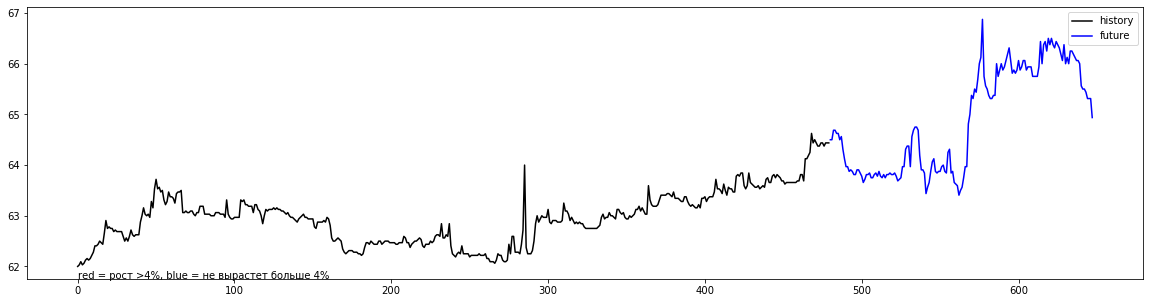

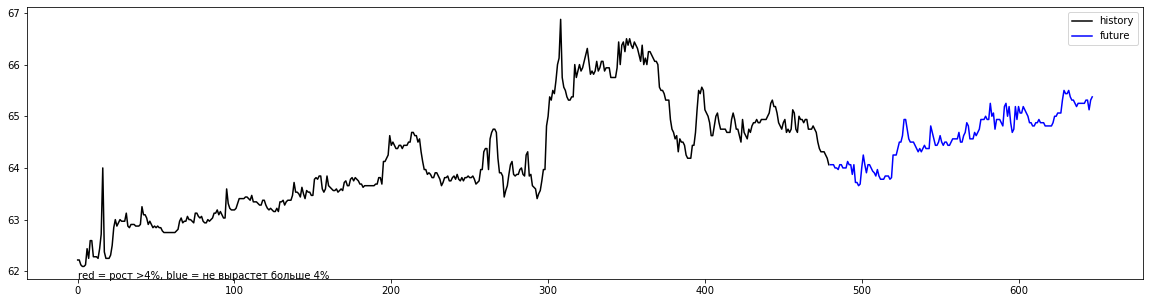

In [37]:
plot_graph(609)
plot_graph(610)

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [61]:
sgd_clf = SGDClassifier(n_jobs = -1)
dt_clf = DecisionTreeClassifier(max_depth = 40)
knn_clf = KNeighborsClassifier(n_neighbors=10, n_jobs = -1)
rf_clf = RandomForestClassifier(n_estimators=20, max_depth=40, n_jobs = -1)
mlp_clf = MLPClassifier(hidden_layer_sizes=(1000,100))

In [40]:
from sklearn.metrics import f1_score, cohen_kappa_score

In [41]:
import time

In [42]:
current_time = time.time()
rf_clf.fit(ds_x_train,ds_y_train[:,0])
elapsed_time = (time.time() - current_time) / 60
print(elapsed_time)

0.03496526877085368


In [62]:
current_time = time.time()
mlp_clf.fit(ds_x_train,ds_y_train[:,0])
elapsed_time = (time.time() - current_time) / 60
print(elapsed_time)

41.63955252965291


In [63]:
f1_score(ds_y_train[:,0], mlp_clf.predict(ds_x_train))

0.0

In [64]:
cohen_kappa_score(ds_y_train[:,0], mlp_clf.predict(ds_x_train))

0.0

In [45]:
test_pred = rf_clf.predict(ds_x_test)

In [46]:
f1_score(ds_y_test[:,0], test_pred)

0.9628844114528102

In [47]:
cohen_kappa_score(ds_y_test[:,0], test_pred)

0.9594601268341715

In [48]:
import matplotlib.pyplot as plt

In [65]:
counter = 0
for idx, element in enumerate(test_pred):
    if element == 1 and ds_y_test[idx,0] == 1:
        print(idx)
#         counter += 1
# print(counter * 100/ len(test_pred))

0
20
54
84
86
103
104
112
135
157
168
170
208
247
282
289
331
344
351
361
362
377
388
397
416
425
431
432
437
442
476
477
483
486
497
508
509
521
539
545
553
554
556
590
591
592
596
618
622
639
654
655
659
665
691
698
702
708
736
748
772
782
813
829
843
844
848
862
865
866
878
889
895
900
910
918
939
950
957
963
1009
1014
1020
1038
1049
1063
1075
1081
1096
1098
1121
1125
1144
1148
1155
1172
1173
1198
1219
1224
1235
1236
1237
1293
1315
1349
1353
1360
1375
1386
1392
1432
1445
1447
1452
1489
1511
1515
1530
1553
1562
1576
1580
1595
1600
1611
1616
1627
1645
1646
1661
1672
1678
1689
1701
1703
1716
1722
1725
1726
1735
1738
1756
1790
1795
1812
1813
1815
1820
1822
1827
1833
1837
1859
1864
1872
1874
1877
1887
1909
1917
1918
1934
1951
1960
1967
1968
2003
2006
2025
2031
2057
2069
2079
2094
2126
2146
2147
2150
2152
2154
2165
2179
2199
2213
2216
2250
2255
2283
2317
2331
2348
2353
2372
2385
2387
2389
2407
2409
2417
2441
2453
2483
2484
2485
2494
2498
2505
2513
2526
2527
2531
2532
2540
2556
2561
2578
2

1.0


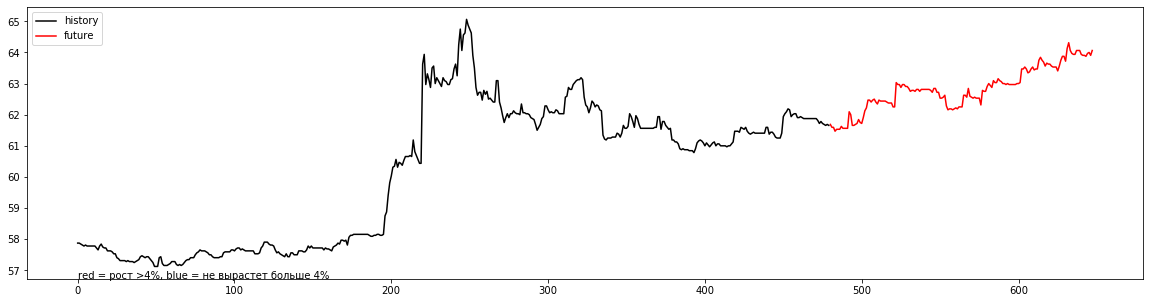

In [69]:
number = 104
plot_graph(number, use_train_set= False)
print(test_pred[number])

In [52]:
from sklearn.model_selection import GridSearchCV

In [54]:
param_grid = [{'n_estimators':[80,83,85,85,90,93,95,97,103,105,107],
               'max_depth':[70,75,80,77,83,85,87],
#                'min_samples_split':[2,5,10],
               'min_samples_leaf': [2],
               'max_features':[6]}]

In [55]:
grid_search = GridSearchCV(rf_clf, param_grid, cv = 10, n_jobs=-1)
grid_search.fit(ds_x_train,ds_y_train[:,0])
grid_search.best_params_

{'max_depth': 80, 'max_features': 6, 'min_samples_leaf': 2, 'n_estimators': 85}

In [56]:
rf_clf.max_depth = 80
rf_clf.n_estimators = 85
rf_clf.fit(ds_x_train,ds_y_train[:,0])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [57]:
test_pred = rf_clf.predict(ds_x_test)

In [58]:
cohen_kappa_score(ds_y_test[:,0], test_pred)

0.9526016272622553

In [59]:
f1_score(ds_y_test[:,0], test_pred)

0.9566137566137567